# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import os

from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Testing if cuda is on GPU

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


# Spatial Data Generation


In [3]:
path = './data/hmdb51'
path_rowframes = './data/hmdb51/rawframes/'
path_annotations = './data/hmdb51/annotations/'

img_height = 224
img_width = 224
batch_size = 64
num_classes = 51

num_frames_desired = 17     #number of frames per clip
type_frame = 'img'          #img / flow_x / flow_y

In [4]:
def sampling(list, num_frames_desired):
    step = len(list) // (num_frames_desired)
    #selected_frames = list(range(0, len(list), step))[:num_frames_desired]
    sampled_list = list[0:len(list):step][:num_frames_desired]
    return(sampled_list)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.image.random_flip_left_right(image)
    #print(image.shape)
    #print(tf.TensorShape(image))
    
    #if image.shape[1] < img_width:
    
    #else:
    #image = tf.image.random_crop(image, [img_height, img_width, 3])
    
    #print(image.shape)
    #image = tf.image.random_saturation(image, 5, 10)
    #image = tf.image.random_brightness(image, 0.2)
    #image = tf.image.random_contrast(image, 0.2, 0.5)
    
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def find_paths(partition, type_frame, num_frames_desired):
    if partition == 'train':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_train_split_1_rawframes.txt', sep=" ", header=None) #train
        video_list.columns = ["path", "num_frames_tot", "class"]
    elif partition == 'val':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_val_split_1_rawframes.txt', sep=" ", header=None) #test
        video_list.columns = ["path", "num_frames_tot", "class"]
    else:
        raise Exception("invalid partition")

    paths = []
    classes = []
    for index, row in video_list.iterrows(): 
        temp_path = row['path']
        frame_list = os.listdir(os.path.join(f'./{temp_path}'))

        frame_list_type = [i for i in frame_list if i.startswith(f'{type_frame}')]

        filename = sampling(frame_list_type, num_frames_desired)

        paths.extend([os.path.join('.\\', temp_path, file) for file in filename])
        temp = [row['class']] * num_frames_desired
        classes.extend(temp)

    return(list(zip(paths, classes)), video_list)

In [5]:
# verify class balance
filenames, video_list = find_paths(partition='train', type_frame=type_frame, num_frames_desired=num_frames_desired)
video_list[['cose', 'class', 'vid']] = video_list["path"].str.rsplit("\\", n = 2, expand = True)
video_list.groupby('class').count().head()

,path,num_frames_tot,cose,vid
class,,,,
brush_hair,70,70,70,70
cartwheel,70,70,70,70
catch,70,70,70,70
chew,70,70,70,70
clap,70,70,70,70


In [6]:
# ------- create train set
#filenames = find_paths(partition='train', type_frame=type_frame, num_frames_desired=num_frames_desired)

random.shuffle(filenames)

zipped = [list(t) for t in zip(*filenames)]

filenames = zipped[0]
labels = zipped[1]

filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

labels_ds = tf.data.Dataset.from_tensor_slices(labels)
ds = tf.data.Dataset.zip((images_ds, labels_ds))
train_ds = configure_for_performance(ds)


In [7]:
frame_number_train = len(filenames)
print(frame_number_train)

60690


In [8]:
#train_ds
#img = tf.expand_dims(images_ds, 0)
#plt.imshow(img[0])

from math import sqrt

'''
plt.figure(figsize=(20, 20))
#class_names = test_data.class_names
for images, labels in train_ds.take(1):
    for i in range(batch_size):
        ax = plt.subplot(int(sqrt(batch_size))+1, int(sqrt(batch_size)), i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.savefig('batch_images.jpg')
'''

'\nplt.figure(figsize=(20, 20))\n#class_names = test_data.class_names\nfor images, labels in train_ds.take(1):\n    for i in range(batch_size):\n        ax = plt.subplot(int(sqrt(batch_size))+1, int(sqrt(batch_size)), i + 1)\n        plt.imshow(images[i].numpy().astype("uint8"))\n        #plt.title(class_names[labels[i]])\n        plt.axis("off")\n        plt.savefig(\'batch_images.jpg\')\n'

In [9]:
def sampling(list, num_frames_desired):
    step = len(list) // (num_frames_desired)
    #selected_frames = list(range(0, len(list), step))[:num_frames_desired]
    sampled_list = list[0:len(list):step][:num_frames_desired]
    return(sampled_list)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    print(image.shape)
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def find_paths(partition, type_frame, num_frames_desired):
    if partition == 'train':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_train_split_1_rawframes.txt', sep=" ", header=None) #train
        video_list.columns = ["path", "num_frames_tot", "class"]
    elif partition == 'val':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_val_split_1_rawframes.txt', sep=" ", header=None) #test
        video_list.columns = ["path", "num_frames_tot", "class"]
    else:
        raise Exception("invalid partition")

    paths = []
    classes = []
    for index, row in video_list.iterrows(): 
        temp_path = row['path']
        frame_list = os.listdir(os.path.join(f'./{temp_path}'))

        frame_list_type = [i for i in frame_list if i.startswith(f'{type_frame}')]

        filename = sampling(frame_list_type, num_frames_desired)

        paths.extend([os.path.join('.\\', temp_path, file) for file in filename])
        temp = [row['class']] * num_frames_desired
        classes.extend(temp)

    return(list(zip(paths, classes)), video_list)

In [10]:
# ------- create val test
filenames, video_list = find_paths(partition='val', type_frame=type_frame, num_frames_desired=num_frames_desired)

random.shuffle(filenames)

zipped = [list(t) for t in zip(*filenames)]

filenames = zipped[0]
labels = zipped[1]

filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
ds = tf.data.Dataset.zip((images_ds, labels_ds))
val_ds = configure_for_performance(ds)

(224, 224, 3)


In [11]:
frame_number_val = len(filenames)
print(frame_number_val)

26010


In [12]:
step_per_epoch_train = frame_number_train // batch_size
step_per_epoch_val = frame_number_val // batch_size
print(step_per_epoch_train)
print(step_per_epoch_val)

948
406


# Spatial Stream Finetuned

In [13]:
checkpoint_filepath = './Models/spatial_model{epoch:02d}-{val_loss:.2f}.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

## ResNet 1

In [14]:
version = 3
arc = 'boh'
epochs = 5
learningrate = 0.0001
momentum = 0

In [15]:
# versione 2
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=(-0.15, 0.2))
])


input = tf.keras.layers.Input(shape=(img_height, img_width, 3))

x = tf.keras.applications.resnet50.preprocess_input(input, data_format=None)
#x = data_augmentation(x)


pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_tensor=x,
                                                  pooling='avg',
                                                  weights='imagenet')
pretrained_model.trainable = False

resnet_model = tf.keras.Sequential()

resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
#resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(num_classes, activation='softmax'))

print(resnet_model.summary())


#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0)
optimizer = Adam(learning_rate=learningrate)
resnet_model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 51)                104499    
                                                                 
Total params: 23,692,211
Trainable params: 104,499
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [17]:
history_ResNet1_spatial_stream = resnet_model.fit(train_ds, 
                                        validation_data = val_ds, 
                                        epochs=epochs, 
                                        batch_size = batch_size,
                                        steps_per_epoch=step_per_epoch_train,
                                        validation_steps=step_per_epoch_val,
                                        callbacks=[model_checkpoint_callback]
                                        )

Epoch 1/5
948/948 [==============================] - 435s 444ms/step - loss: 2.2442 - sparse_categorical_accuracy: 0.4444 - sparse_top_k_categorical_accuracy: 0.7078 - val_loss: 2.3705 - val_sparse_categorical_accuracy: 0.3721 - val_sparse_top_k_categorical_accuracy: 0.6886
Epoch 2/5
948/948 [==============================] - 429s 451ms/step - loss: 1.1961 - sparse_categorical_accuracy: 0.7058 - sparse_top_k_categorical_accuracy: 0.9071 - val_loss: 2.2918 - val_sparse_categorical_accuracy: 0.3872 - val_sparse_top_k_categorical_accuracy: 0.7065
Epoch 3/5
948/948 [==============================] - 426s 449ms/step - loss: 0.8997 - sparse_categorical_accuracy: 0.7842 - sparse_top_k_categorical_accuracy: 0.9410 - val_loss: 2.3006 - val_sparse_categorical_accuracy: 0.3901 - val_sparse_top_k_categorical_accuracy: 0.7166
Epoch 4/5
948/948 [==============================] - 427s 451ms/step - loss: 0.7292 - sparse_categorical_accuracy: 0.8285 - sparse_top_k_categorical_accuracy: 0.9597 - val_los

In [21]:
score = resnet_model.evaluate(val_ds, verbose=1, batch_size = batch_size, steps=step_per_epoch_val)
print('Loss val:', score[0])
print('Sparse_categorical_accuracy:', score[1])
print('Sparse_top_5_categorical_accuracy:', score[2])

406/406 [==============================] - 124s 304ms/step - loss: 2.3686 - sparse_categorical_accuracy: 0.3871 - sparse_top_k_categorical_accuracy: 0.7171
Loss val: 2.3685786724090576
Sparse_categorical_accuracy: 0.38712283968925476
Sparse_top_5_categorical_accuracy: 0.717133641242981


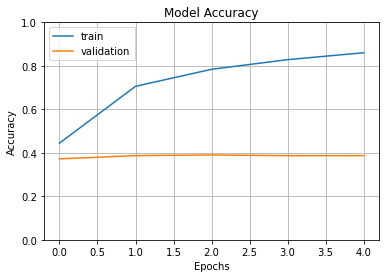

In [20]:
fig1 = plt.gcf()
plt.plot(history_ResNet1_spatial_stream.history['sparse_categorical_accuracy'])
plt.plot(history_ResNet1_spatial_stream.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('./Report/Plots/resnet1_2.png')
plt.show()

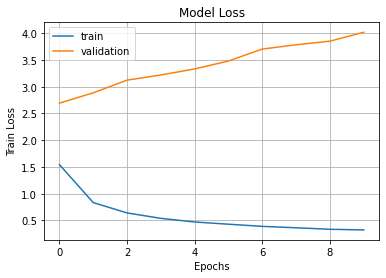

In [21]:
from ensurepip import version
from platform import architecture


fig1 = plt.gcf()
plt.plot(history_ResNet1_spatial_stream.history['loss'])
plt.plot(history_ResNet1_spatial_stream.history['val_loss'])
#plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
metric_plot = 'loss'
plt.ylabel('Train Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig(f'./Report/Plots/spatial_stream/spatialstream_{arc}_epoch{epochs}_batch{batch_size}optSDG{learningrate}{momentum}_metric{metric_plot}_train.png')
plt.show()


In [ ]:
resnet_model.save(f'./Models/motion_stream/motionstream{version}_epoch{epochs}_batch{batch_size}_optSDG_lr{learningrate}_momentum{momentum}.h5')

## ResNet 2

In [ ]:
def build_model(num_classes, img_size=224):
    input = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    model = tf.keras.applications.ResNet50(include_top=False, input_tensor=input, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    output = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(input, output, name="ResNet")
    #model.compile(optimizer='adam', loss = "sparse_categorical_crossentropy", metrics = ['sparse_categorical_accuracy'])
    model.compile(optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999,), 
                  loss = "sparse_categorical_crossentropy", 
                  metrics = ['sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy'])
                    
    return model 

model = build_model(num_classes)
print(model.summary())

In [11]:
history_ResNet2_spatial_stream = model.fit(train_ds, 
                                        validation_data = val_ds, 
                                        batch_size=batch_size, 
                                        epochs=5, 
                                        steps_per_epoch=step_per_epoch_train, 
                                        validation_steps=step_per_epoch_val,
                                        callbacks=[model_checkpoint_callback])

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "c:\ProgramData\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\ProgramData\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\gianl\AppData\Local\Temp/ipykernel_3268/3751188769.py", line 1, in <module>
      history_ResNet2_spatial_stream = model.fit(train_ds,
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1039, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "c:\ProgramData\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\ProgramData\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\gianl\AppData\Local\Temp/ipykernel_3268/3751188769.py", line 1, in <module>
      history_ResNet2_spatial_stream = model.fit(train_ds,
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1039, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Cannot batch tensors with different shapes in component 0. First element had shape [240,320,3] and element 12 had shape [240,352,3].
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  Cannot batch tensors with different shapes in component 0. First element had shape [240,320,3] and element 12 had shape [240,352,3].
	 [[{{node IteratorGetNext}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_8957]

In [36]:
score = model.evaluate(val_ds, verbose=1, batch_size = batch_size, steps=step_per_epoch_val)
print('Loss val:', score[0])
print('Sparse_categorical_accuracy:', score[1])
print('Sparse_top_5_categorical_accuracy:', score[2])

406/406 [==============================] - 125s 308ms/step - loss: 2.7244 - sparse_categorical_accuracy: 0.3468 - sparse_top_k_categorical_accuracy: 0.6810
Loss val: 2.724404811859131
Sparse_categorical_accuracy: 0.3467518389225006
Sparse_top_5_categorical_accuracy: 0.681034505367279


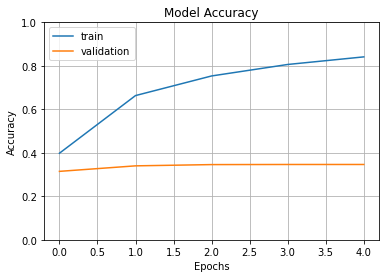

In [38]:
fig2 = plt.gcf()
plt.plot(history_ResNet2_spatial_stream.history['sparse_categorical_accuracy'])
plt.plot(history_ResNet2_spatial_stream.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('./Plots/resnet2_1.png')
plt.show()

# Full video evaluation

In [13]:
resnet_model = keras.models.load_model('./Models/spatial_model_finetuned_resnet_best.hdf5')

In [ ]:
score = resnet_model.evaluate(val_ds, verbose=1, batch_size = batch_size, steps=step_per_epoch_val)
print('Loss val:', score[0])
print('Sparse_categorical_accuracy:', score[1])
print('Sparse_top_5_categorical_accuracy:', score[2])

In [14]:
class_ind = pd.read_csv("./data/hmdb51/annotations/classInd.txt", sep=" ", header=None)
class_ind.columns = ["class_ind", "class"]
class_ind['class_ind'] = class_ind['class_ind'] - 1
class_ind.set_index('class_ind', inplace=True)
class_ind.head(10)
class_ind_copy = class_ind.copy()

In [15]:
def find_paths(partition, type_frame):
    if partition == 'train':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_train_split_1_rawframes.txt', sep=" ", header=None) #train
        video_list.columns = ["path", "num_frames_tot", "class"]
    elif partition == 'val':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_val_split_1_rawframes.txt', sep=" ", header=None) #test
        video_list.columns = ["path", "num_frames_tot", "class"]
    else:
        raise Exception("invalid partition")


    paths = []
    classes = []
    for index, row in video_list.iterrows():
        temp_path = row['path']
        frame_list = os.listdir(os.path.join(f'./{temp_path}'))

        frame_list_type = [i for i in frame_list if i.startswith(f'{type_frame}')]

        filename = frame_list_type

        paths.append([os.path.join('.\\', temp_path, file) for file in filename])
        temp = [row['class']] * len(filename)
        classes.append(temp)

    return(paths, classes)

In [16]:
filenames_img, labels = find_paths(partition='val', type_frame='img')

In [17]:
# ------ all in one (for loop)
#random_video_frames_path = random.choice(filenames_img)

from imgaug import augmenters as iaa

random.shuffle(filenames_img)
top1 = 0
top5 = 0
miss = 0


for count, video_frames_path in enumerate(filenames_img[:200]):

    #print(len(video_frames_path))
    class_ind = class_ind_copy.copy()

    original_rgb_frames = []

    for frame in video_frames_path:
        original_rgb_frames.append(cv2.imread(frame, cv2.IMREAD_UNCHANGED))

    # generate spatial batch as done in the dataloader
    spatial_batch_temp = []
    for image in original_rgb_frames:
        spatial_batch_temp.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        #spatial_batch_temp.append(image) - [103.939, 116.779, 123.68]) #peggiora se non si fa BGR2RGB e se si toglie la media

    # image resize augmenter to be fed into the network
    
    augmenter = iaa.Sequential([
        iaa.Resize((img_height, img_width))
        #iaa.CropToFixedSize(img_height, img_width)
    ])
    spatial_batch = np.array(augmenter.augment_images(spatial_batch_temp), dtype=np.float32)# /255.0

    true_class = video_frames_path[0].split('\\')[4]
    #print(true_class)

    # predict spatial stream output
    try:
        spatial_pred = resnet_model.predict(spatial_batch)
    except:
        print('saltatoooooo')
    spatial_classes = np.argsort(spatial_pred,axis=1)#[:,:-6:-1]
    spatial_scores = np.sort(spatial_pred,axis=1)#[:,:-6:-1]

    spatial_sorted = []

    for spatial_class, spacial_score in zip(spatial_classes, spatial_scores):
        zipped = zip(spatial_class, spacial_score)
        spatial_sorted.append(sorted(zipped, key=lambda x: x[0]))

    avg_scores = np.average(spatial_sorted, axis=0)
    class_ind['percentage'] = round(pd.Series(avg_scores[:,1])*100, 1)
    class_ind.sort_values('percentage', ascending=False, inplace=True)
    class_ind = class_ind.head(5)
    class_ind.reset_index('class_ind', inplace = True)


    if class_ind.loc[0]['class'] == true_class:
        #print('top 1')
        top1 += 1
    elif true_class in class_ind['class'].tolist():
        #print('top 5')
        top5 += 1
    else:
        #print('niente')
        miss += 1
    print(count,'/',len(filenames_img))

2/2 [==============================] - 5s 698ms/step
0 / 1530
5/5 [==============================] - 1s 242ms/step
1 / 1530
2/2 [==============================] - 1s 597ms/step
2 / 1530
3/3 [==============================] - 1s 499ms/step
3 / 1530
4/4 [==============================] - 1s 323ms/step
4 / 1530
4/4 [==============================] - 0s 140ms/step
5 / 1530
3/3 [==============================] - 1s 382ms/step
6 / 1530
3/3 [==============================] - 1s 488ms/step
7 / 1530
4/4 [==============================] - 0s 141ms/step
8 / 1530
2/2 [==============================] - 1s 1s/step
9 / 1530
3/3 [==============================] - 1s 566ms/step
10 / 1530
2/2 [==============================] - 1s 846ms/step
11 / 1530
10/10 [==============================] - 1s 143ms/step
12 / 1530
3/3 [==============================] - 0s 141ms/step
13 / 1530
4/4 [==============================] - 1s 359ms/step
14 / 1530
2/2 [==============================] - 1s 702ms/step
15 / 1530
3/3

In [18]:
print(count, top1+top5+miss)
print(top1, top5, miss)

199 200
90 67 43


In [19]:
print(top1/(count+1), (top1+top5)/(count+1))

0.45 0.785


In [168]:
# load frames of random video
from ctypes import resize

random_video_frames_path = random.choice(filenames_img)

In [169]:
original_rgb_frames = []

for frame in random_video_frames_path:
    original_rgb_frames.append(cv2.imread(frame, cv2.IMREAD_UNCHANGED))


# generate spatial batch as done in the dataloader
spatial_batch_temp = []
for image in original_rgb_frames:
    spatial_batch_temp.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #spatial_batch_temp.append(image) - [103.939, 116.779, 123.68]) #peggiora se non si fa BGR2RGB e se si toglie la media



In [170]:
# image resize augmenter to be fed into the network
from imgaug import augmenters as iaa
augmenter = iaa.Sequential([
    iaa.Resize((img_height, img_width))
    #iaa.CropToFixedSize(img_height, img_width)
])
spatial_batch = np.array(augmenter.augment_images(spatial_batch_temp), dtype=np.float32)# /255.0

Class:  ride_bike


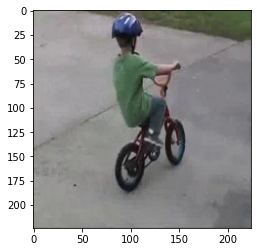

In [171]:
print('Class: ', random_video_frames_path[0].split('\\')[4])
plt.imshow(spatial_batch[0]/255)

In [172]:
# predict spatial stream output
spatial_pred = resnet_model.predict(spatial_batch)
spatial_classes = np.argsort(spatial_pred,axis=1)#[:,:-6:-1]
spatial_scores = np.sort(spatial_pred,axis=1)#[:,:-6:-1]

spatial_sorted = []

for spatial_class, spacial_score in zip(spatial_classes, spatial_scores):
    zipped = zip(spatial_class, spacial_score)
    spatial_sorted.append(sorted(zipped, key=lambda x: x[0]))

3/3 [==============================] - 1s 258ms/step


In [173]:
avg_scores = np.average(spatial_sorted, axis=0)
class_ind['percentage'] = round(pd.Series(avg_scores[:,1])*100, 1)
class_ind.sort_values('percentage', ascending=False, inplace=True)
class_ind.head(10)

,class,percentage
class_ind,,
30,ride_bike,87.5
28,push,2.9
24,pick,2.0
32,run,1.2
44,sword,1.1
41,somersault,0.9
47,throw,0.8
17,hit,0.5
9,dribble,0.4


In [175]:
# find path
#filenames_flow_x, labels = find_paths(partition='val', type_frame='flow_x', num_frames_desired=num_frames_desired)
#filenames_flow_y, labels = find_paths(partition='val', type_frame='flow_y', num_frames_desired=num_frames_desired)

# optical flow
'''
# make the optical flow frames
original_v_frames = []
original_u_frames = []

frames = list(map(lambda frame: cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0, original_rgb_frames))
optical_flow = cv2.optflow.DualTVL1OpticalFlow_create()

for frame_index in range(len(frames) - 1):
    if frame_index % 10 == 0:
        print("processing tvl flow of frame ",frame_index)

    flow = optical_flow.calc(frames[frame_index], frames[frame_index + 1], None)
    u_frame = convert_to_image(flow[..., 0])
    v_frame = convert_to_image(flow[..., 1])

    original_v_frames.append(v_frame)
    original_u_frames.append(u_frame)

print("original_rgb_frames:", len(original_rgb_frames), "original_u_frames:", len(original_u_frames), "original_v_frames:", len(original_v_frames))
'''

# generate motion batch as done in the dataloade

'''
motion_batch = []

for first_optical_frame_id in range(len(original_u_frames) - stacked_frames):
    motion_batch.append(  # append one sample which is (h,w,stacked*2)
        stack_opticalflow(start_frame_index=first_optical_frame_id, stacked_frames=stacked_frames)
    )
motion_batch = np.array(augmenter.augment_images(motion_batch), dtype=np.float32) / 255.0
'''


#zipped
"""
predict motion stream output

motion_pred = motion_model_restored.predict(motion_batch)
motion_classes = np.argsort(motion_pred,axis=1)[:,:-6:-1]
motion_scores = np.sort(motion_pred,axis=1)[:,:-6:-1]

get the average output prediction
average_pred = motion_pred + spatial_pred[:motion_pred.shape[0],]
average_classes = np.argsort(average_pred,axis=1)[:,:-6:-1]
average_scores = np.sort(average_pred,axis=1)[:,:-6:-1]
"""

'\npredict motion stream output\n\nmotion_pred = motion_model_restored.predict(motion_batch)\nmotion_classes = np.argsort(motion_pred,axis=1)[:,:-6:-1]\nmotion_scores = np.sort(motion_pred,axis=1)[:,:-6:-1]\n\nget the average output prediction\naverage_pred = motion_pred + spatial_pred[:motion_pred.shape[0],]\naverage_classes = np.argsort(average_pred,axis=1)[:,:-6:-1]\naverage_scores = np.sort(average_pred,axis=1)[:,:-6:-1]\n'

# Animation creation

In [102]:
high_resolution_video = True # for good internet :D

def make_bar_chart(classes,scores):
    height = scores.tolist()
    bars = [action_names[class_index] for class_index in classes]
    y_pos = np.arange(len(bars))
    
    bar = plt.bar(y_pos, height, color=['yellow', 'red', 'green', 'blue', 'cyan'])
    # plt.xticks(y_pos, bars, rotation=90) this will draw them below
    # plt.tick_params(axis="x",labelsize=10,direction="in", pad=-15)
    plt.ylim(top=1)  
    plt.ylim(bottom=0) 
    
    for bar_id,rect in enumerate(bar):
        plt.text(rect.get_x() + rect.get_width()/2.0, .5, bars[bar_id], ha='center', va='center', rotation=75,fontdict={'fontsize': 13 if high_resolution_video else 10})

In [103]:
make_bar_chart(spatial_classes[0],spatial_scores[0])

NameError: name 'bars' is not defined

In [67]:
# Define the codec and create VideoWriter object.The output is stored in 'demo.mp4' file.
import skvideo.io

writer = skvideo.io.FFmpegWriter("demo.mp4", inputdict={
      '-r': '16',
    })

gs = gridspec.GridSpec(2, 3,
                       width_ratios=[1, 1,1],
                       height_ratios=[1.5, 1]
                       )

gs.update(wspace=0.2,hspace=0)

# generating output video
for frame_index in range(motion_classes.shape[0]): 
    if high_resolution_video :
        fig = plt.figure(figsize=(16, 12))
        fig.suptitle("Demo for {}".format(video_name), fontsize=24)

        fig.text(.125,0.91,"Average Prediction from spatial stream: {}".format(action_names[np.mean(spatial_pred,axis = 0).argmax()]),color='r', fontsize=18)
        fig.text(.125,.87,"Average Prediction from motion stream: {}".format(action_names[np.mean(motion_pred,axis = 0).argmax()]),color='g',fontsize=18)
        fig.text(.125,.83,"Average Prediction from both streams: {}".format(action_names[np.mean(average_pred,axis = 0).argmax()]),color='b', fontsize=18)
    else :
        fig = plt.figure(figsize=(9, 6))
        fig.suptitle("Demo for {}".format(video_name), fontsize=16)

        fig.text(.125,0.91,"Average Prediction from spatial stream: {}".format(action_names[np.mean(spatial_pred,axis = 0).argmax()]),color='r', fontsize=13)
        fig.text(.125,.87,"Average Prediction from motion stream: {}".format(action_names[np.mean(motion_pred,axis = 0).argmax()]),color='g',fontsize=13)
        fig.text(.125,.83,"Average Prediction from both streams: {}".format(action_names[np.mean(average_pred,axis = 0).argmax()]),color='b', fontsize=13)
    

    if frame_index % 10 == 0:
        print("processing frame ",frame_index)
    ##########################################################
    # rgb frame
    ax = plt.subplot(gs[0])
    ax.set_title("RGB frame", fontsize=16 if high_resolution_video else 13)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(cv2.cvtColor(original_rgb_frames[frame_index],cv2.COLOR_RGB2BGR))
    ##########################################################
    # optical flow frame
    ax = plt.subplot(gs[1])
    ax.set_title("TVL1 Optical flow u-frame", fontsize=16 if high_resolution_video else 13)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(original_u_frames[frame_index],cmap="inferno") # viridis,inferno,plasma,magma
    ##########################################################
    # optical flow frame
    ax = plt.subplot(gs[2])
    ax.set_title("TVL1 Optical flow v-frame", fontsize= 16 if high_resolution_video else 13)

    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(original_v_frames[frame_index],cmap="inferno") # viridis,inferno,plasma,magma
    ##########################################################
    # prediction scores
    ax = plt.subplot(gs[3])
    ax.set_title("Spatial Stream Output scores",fontsize= 16 if high_resolution_video else 13)

    make_bar_chart(spatial_classes[frame_index],spatial_scores[frame_index])
    ##########################################################
    # prediction scores
    ax = plt.subplot(gs[4])
    ax.set_title("Motion Stream Output scores",fontsize= 16 if high_resolution_video else 13)

    make_bar_chart(motion_classes[frame_index],motion_scores[frame_index])
    ##########################################################
    # prediction scores
    ax = plt.subplot(gs[5])
    ax.set_title("Average Output scores",fontsize= 16 if high_resolution_video else 13)

    make_bar_chart(average_classes[frame_index],average_scores[frame_index])
    ##########################################################
    fig.tight_layout( pad=0, h_pad=0, w_pad=0)
    writer.writeFrame(get_image_from_fig(fig))
    
    plt.close(fig)
    
writer.close()

AssertionError: Unknown encoder extension: .gif

In [ ]:
video = io.open("demo.mp4" , 'r+b').read()
encoded = base64.b64encode(video)

HTML(data='''<video controls autoplay loop>
			<source type="video/mp4" src="data:video/mp4;base64,{}"
      		</video>'''.format(encoded.decode('ascii')))

# External video prediction

In [19]:
# Frame creation vid 1

img_path = "C:\\Users\\gianl\\Desktop\\VID_20220830_115011_2.mp4"
cap= cv2.VideoCapture(img_path)
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite(f'C:\\Users\\gianl\\Desktop\\VID_20220830_115011_2\\frame_{i}.jpg',frame)
    i+=1

cap.release()
cv2.destroyAllWindows()

In [20]:
# Frame creation vid 2

img_path = "C:\\Users\\gianl\\Desktop\\VID_20220830_115837_2.mp4"
cap= cv2.VideoCapture(img_path)
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite(f'C:\\Users\\gianl\\Desktop\\VID_20220830_115837_2\\frame_{i}.jpg',frame)
    i+=1

cap.release()
cv2.destroyAllWindows()

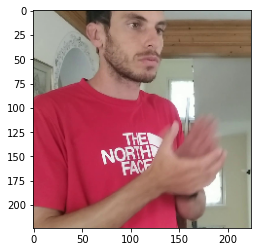

In [115]:
from tensorflow.keras.preprocessing import image

img = image.load_img('C:\\Users\\gianl\\Desktop\\VID_20220830_115011_2\\frame_7.jpg', target_size=(224, 224))

plt.imshow(img)
plt.show()

In [116]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

img_array = image.img_to_array(img)

img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

In [117]:
prediction = resnet_model.predict(img_preprocessed)
print(prediction[0])

1/1 [==============================] - 0s 26ms/step
[2.34737352e-04 2.80613426e-06 2.06132230e-04 2.17731167e-02
 1.88459363e-02 1.17951444e-04 6.84310799e-05 1.74175785e-03
 2.81521445e-03 2.53350063e-05 2.46298907e-04 9.55551211e-03
 1.22938538e-04 1.77506263e-05 7.09710643e-04 6.05761779e-05
 1.42559918e-04 1.61227741e-04 3.17378930e-04 8.89190196e-05
 9.71090049e-04 3.20103165e-04 4.35469759e-04 2.65767910e-02
 7.08426478e-06 8.48668721e-03 1.42214602e-04 5.57961583e-04
 8.40892244e-06 3.99721393e-05 5.58073589e-05 1.20170624e-03
 3.36911976e-02 1.65908709e-02 1.45321079e-02 1.15361828e-02
 1.09464873e-03 2.34421721e-04 1.86969133e-04 2.46176213e-01
 4.39039946e-01 4.31478693e-05 1.27284159e-03 7.31704931e-05
 1.85199138e-02 1.66689613e-04 4.10390378e-04 3.21507454e-02
 8.22452363e-03 9.36539378e-03 7.06331283e-02]


<BarContainer object of 51 artists>

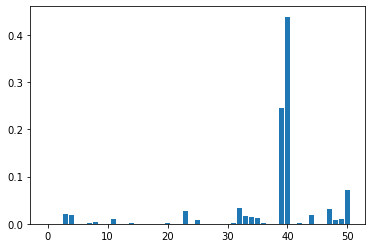

In [118]:
plt.bar(list(range(0,51)), prediction[0])